In [ ]:
!pip install kaggle==1.6.17 --force
!mkdir -p ~/.kaggle
!echo '{"username":"barlasowmya","key":"e8b02c5854d02b68514249a5127b0adb"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.4/163.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.4/128.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 5.7 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()
import random
import json
from sklearn.model_selection import train_test_split
import shutil
import yaml
plt.style.use("ggplot")

In [ ]:
!kaggle datasets download -d mistag/arthropod-taxonomy-orders-object-detection-dataset -p /content/arthropod-taxonomy-orders-object-detection-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/mistag/arthropod-taxonomy-orders-object-detection-dataset
License(s): CC-BY-NC-SA-4.0
100% 11.1G/11.1G [05:01<00:00, 41.7MB/s]
100% 11.1G/11.1G [05:01<00:00, 39.6MB/s]


In [ ]:
dataset_path = "/content/arthropod-taxonomy-orders-object-detection-dataset"

In [ ]:
import pandas as pd
import json
from glob import glob
from tqdm import tqdm

dataset_path = "/content/arthropod-taxonomy-orders-object-detection-dataset"

# Only include annotations from 'Araneae' and 'Coleoptera'
annotation_list = (
    glob(f"{dataset_path}/ArTaxOr/Araneae/annotations/*.json") +
    glob(f"{dataset_path}/ArTaxOr/Coleoptera/annotations/*.json")
)

data = pd.DataFrame()
data["annotation_dir"] = annotation_list

# Define the allowed classes
allowed_classes = {"Coleoptera": 0, "Araneae": 1}

def read_json_data(jsonfile):
    rows = {
        "id": [], "img_dir": [], "img_w": [], "img_h": [], "x": [], "y": [], "w": [], "h": [],
        "sp_type": [], "xc": [], "yc": [], "bb_height": [], "bb_width": [], "bb_left": [], "bb_top": []
    }

    with open(jsonfile) as f:
        json_f = json.load(f)

    for region in json_f["regions"]:
        sp_type = region["tags"][0]

        # Only keep annotations of 'Araneae' and 'Coleoptera'
        if sp_type not in allowed_classes:
            continue  # Skip annotations of unwanted classes

        id = json_f["asset"]["id"]
        img_dir = json_f["asset"]["path"].replace(dataset_path, "").lstrip("/")
        img_w = json_f["asset"]["size"]["width"]
        img_h = json_f["asset"]["size"]["height"]

        x = region["boundingBox"]["left"]
        y = region["boundingBox"]["top"]
        w = region["boundingBox"]["width"]
        h = region["boundingBox"]["height"]

        # Normalize Bounding Box
        bb_height = h / img_h
        bb_width = w / img_w
        bb_left = x / img_w
        bb_top = y / img_h

        xcenter = x / img_w + 0.5 * bb_width
        ycenter = y / img_h + 0.5 * bb_height

        rows["id"].append(id)
        rows["img_dir"].append(img_dir)
        rows["sp_type"].append(allowed_classes[sp_type])  # Convert class name to number
        rows["img_w"].append(img_w)
        rows["img_h"].append(img_h)
        rows["x"].append(x)
        rows["y"].append(y)
        rows["w"].append(w)
        rows["h"].append(h)
        rows["bb_height"].append(bb_height)
        rows["bb_width"].append(bb_width)
        rows["bb_left"].append(bb_left)
        rows["bb_top"].append(bb_top)
        rows["xc"].append(xcenter)
        rows["yc"].append(ycenter)

    return rows


# Process JSON files
data_list = [pd.DataFrame.from_dict(read_json_data(json_file)) for json_file in tqdm(data["annotation_dir"])]

# Concatenate all dataframes
df = pd.concat(data_list, ignore_index=True)
df = df[df["img_dir"].str.contains("ArTaxOr/Araneae|ArTaxOr/Coleoptera")]

# Display first few rows
print(df.head())


100%|██████████| 4528/4528 [00:03<00:00, 1403.12it/s]


                                 id                                   img_dir  \
0  8b68b542aa05875a6ebd8532d69317d4  file:F:/ArTaxOr/Araneae/8ab7503d66fc.jpg   
1  9ff58618e9f047f3f3f7e13d07407657  file:F:/ArTaxOr/Araneae/87a17260135d.jpg   
2  5fba26d79bdefcc4e2c38066ec94df66  file:F:/ArTaxOr/Araneae/bc6607fe7533.jpg   
3  1e89a13a4852012f5fc3d2ffb67841c4  file:F:/ArTaxOr/Araneae/49996822e484.jpg   
4  188d6684a40dc1817e471ddcec792b9c  file:F:/ArTaxOr/Araneae/3131c4b33513.jpg   

    img_w   img_h           x           y            w            h  sp_type  \
0  1536.0  2048.0  171.647510  207.938697  1364.352490  1149.547893      1.0   
1  3326.0  2270.0  891.670572  903.772412  1517.444521   946.979798      1.0   
2  2048.0  1571.0  310.736223  269.357280  1417.498898   884.816092      1.0   
3  2048.0  1365.0  873.681599  604.951202   254.059269   225.853154      1.0   
4  2048.0  1536.0  636.411215  411.514019   599.327103   730.915888      1.0   

         xc        yc  bb_height

In [ ]:
print("DataFrame Shape:", df.shape)  # (rows, columns)


DataFrame Shape: (5167, 15)


In [ ]:
df.head()

,id,img_dir,img_w,img_h,x,y,w,h,sp_type,xc,yc,bb_height,bb_width,bb_left,bb_top
0,8b68b542aa05875a6ebd8532d69317d4,file:F:/ArTaxOr/Araneae/8ab7503d66fc.jpg,1536.0,2048.0,171.647510,207.938697,1364.352490,1149.547893,1.0,0.555875,0.382184,0.561303,0.888250,0.111750,0.101533
1,9ff58618e9f047f3f3f7e13d07407657,file:F:/ArTaxOr/Araneae/87a17260135d.jpg,3326.0,2270.0,891.670572,903.772412,1517.444521,946.979798,1.0,0.496210,0.606723,0.417172,0.456237,0.268091,0.398138
2,5fba26d79bdefcc4e2c38066ec94df66,file:F:/ArTaxOr/Araneae/bc6607fe7533.jpg,2048.0,1571.0,310.736223,269.357280,1417.498898,884.816092,1.0,0.497796,0.453065,0.563218,0.692138,0.151727,0.171456
3,1e89a13a4852012f5fc3d2ffb67841c4,file:F:/ArTaxOr/Araneae/49996822e484.jpg,2048.0,1365.0,873.681599,604.951202,254.059269,225.853154,1.0,0.488629,0.525918,0.165460,0.124052,0.426602,0.443188
4,188d6684a40dc1817e471ddcec792b9c,file:F:/ArTaxOr/Araneae/3131c4b33513.jpg,2048.0,1536.0,636.411215,411.514019,599.327103,730.915888,1.0,0.457068,0.505841,0.475857,0.292640,0.310748,0.267913


In [ ]:
# Define the allowed categories
allowed_categories = ["/ArTaxOr/Araneae/", "/ArTaxOr/Coleoptera/"]

# Find rows where 'img_dir' does not contain allowed categories
invalid_rows = df[~df["img_dir"].str.contains("|".join(allowed_categories))]

# Print results
if not invalid_rows.empty:
    print("Found unexpected image directories:")
    print(invalid_rows["img_dir"].unique())  # Show unique unexpected directories
else:
    print("All image directories are within Araneae and Coleoptera.")


All image directories are within Araneae and Coleoptera.


In [ ]:
def display_random_imgs(df , rows , cols):
    idxs = random.sample(df.index.tolist() , rows*cols)
    fig , ax = plt.subplots(rows , cols ,figsize = (10,10))
    if rows*cols != 1:
        for count , axs in enumerate(ax.flatten()):

            path = os.path.join(dataset_path, df['img_dir'].iloc[idxs[count]])
            path = os.path.normpath(path)  # Normalize path for cross-platform compatibility
            patch = patches.Rectangle((df.bb_left.iloc[idxs[count]] * df.img_w.iloc[idxs[count]],
                                        df.bb_top.iloc[idxs[count]]* df.img_h.iloc[idxs[count]]),
                                        df.bb_width.iloc[idxs[count]]* df.img_w.iloc[idxs[count]],
                                        df.bb_height.iloc[idxs[count]]* df.img_h.iloc[idxs[count]],
                                        linewidth=1, edgecolor='r', facecolor='none')

            img = plt.imread(path)
            axs.imshow(img)
            axs.add_patch(patch)
            axs.axis('off')
            axs.title.set_text(df.sp_type.iloc[idxs[count]])

In [ ]:
# Remove any "file:" or drive-letter prefixes
df["img_dir"] = df["img_dir"].str.replace(r"^file:[A-Za-z]:/", "", regex=True)
df["img_dir"] = df["img_dir"].str.replace(r"^F:/", "", regex=True)  # Remove Windows drive letters if present
df["img_dir"] = df["img_dir"].str.lstrip("/")  # Remove any leading slashes


In [ ]:
print(df["img_dir"].sample(10))  # Check stored paths
print(path)  # Print paths before loading images

1917       ArTaxOr/Araneae/1faff975e94c.jpg
2168       ArTaxOr/Araneae/3f7a4b24c9f7.jpg
1589       ArTaxOr/Araneae/66df3b3e906e.jpg
1215       ArTaxOr/Araneae/89c7e2fb835f.jpg
3382    ArTaxOr/Coleoptera/7678636dd09f.jpg
1634       ArTaxOr/Araneae/70ba46e4c10a.jpg
3958    ArTaxOr/Coleoptera/a2e42cc917d6.jpg
3703    ArTaxOr/Coleoptera/b408034adcd2.jpg
5149    ArTaxOr/Coleoptera/30db0124ae50.jpg
2082       ArTaxOr/Araneae/c7998146a0e4.jpg
Name: img_dir, dtype: object


NameError: name 'path' is not defined

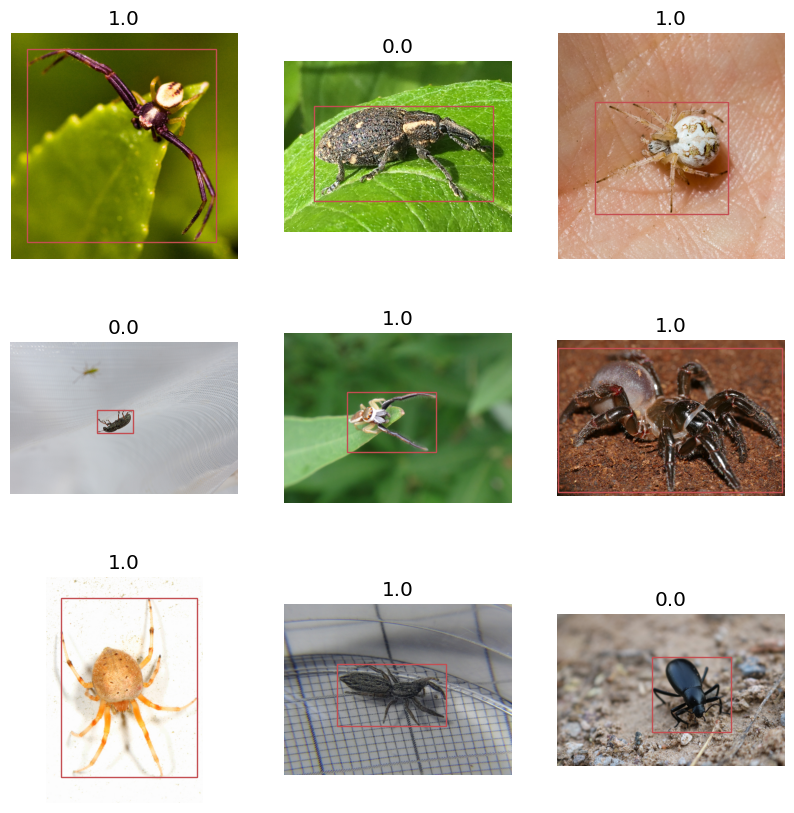

In [ ]:
display_random_imgs(df, 3, 3)

In [ ]:
from sklearn.model_selection import train_test_split

# Initial split: 80% for training, 20% for temp
train, temp = train_test_split(df, test_size=0.2, random_state=42)

# Split the temp set: 1/2 of temp for test, 1/2 of temp for validation (1:1 ratio in temp)
test, valid = train_test_split(temp, test_size=0.5, random_state=42)

In [ ]:
train.shape, test.shape, valid.shape

((4133, 15), (517, 15), (517, 15))

In [ ]:
HOME = os.getcwd()
HOME

'/content'

In [ ]:
train.to_csv(f'{HOME}/train_medata.csv', index=False)
test.to_csv(f'{HOME}/test_medata.csv', index=False)
valid.to_csv(f'{HOME}/valid_medata.csv', index=False)

In [ ]:
!mkdir dataf
!mkdir dataf/train
!mkdir dataf/test
!mkdir dataf/valid

In [ ]:
!mkdir dataf/valid
def add_data_to_folder(file_type, data):
    # Create directories for images and labels if they don’t exist
    os.makedirs(f"{HOME}/dataf/{file_type}/images", exist_ok=True)
    os.makedirs(f"{HOME}/dataf/{file_type}/labels", exist_ok=True)

    for index, row in tqdm(data.iterrows(), total=len(data)):
        # Copy the image to the images folder
        shutil.copy(os.path.join(f'{dataset_path}', row["img_dir"]), f"{HOME}/dataf/{file_type}/images")

        # Create the text file in the labels folder
        txt_filename = f"{HOME}/dataf/{file_type}/labels/{row.img_dir.split('/')[-1][:-4]}.txt"
        with open(txt_filename, "w") as f:
            # Write the annotations in the required format
            f.write(f"{row['sp_type']} {row['xc']} {row['yc']} {row['bb_width']} {row['bb_height']}\n")

mkdir: cannot create directory ‘dataf/valid’: File exists


In [ ]:
classes_name = ["Coleoptera","Araneae"]
classes_num = [0,1]

# class_mapping = dict(zip(classes_num, classes_name))

# Thay đổi giá trị trong cột 'sp_type' theo ánh xạ
train['sp_type'] = train['sp_type'].replace(classes_name , classes_num)
test['sp_type'] = test['sp_type'].replace(classes_name , classes_num)
valid['sp_type'] = valid['sp_type'].replace(classes_name , classes_num)

In [ ]:
add_data_to_folder("train" , train)
add_data_to_folder("test" , test)
add_data_to_folder("valid" , valid)

100%|██████████| 517/517 [00:02<00:00, 188.68it/s]


In [ ]:
# create yml file
yaml_dict = dict(
    train = '../dataf/train',
    test = '../dataf/test',
    val = '../dataf/valid',

    nc    = len(classes_num), # number of classes
    names = classes_name # classes
    )

with open('/content/dataf/data.yaml', 'w') as outfile:
    yaml.dump(yaml_dict, outfile, default_flow_style=False)

%cat /content/dataf/data.yaml

names:
- Coleoptera
- Araneae
nc: 2
test: ../dataf/test
train: ../dataf/train
val: ../dataf/valid


In [ ]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git
!pip install -q supervision
!pip install albumentations==1.4
!pip install -U ultralytics "ray[tune]"
!pip uninstall -y wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 7.5 MB/s 

In [ ]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

total 11M
-rw-r--r-- 1 root root 11M May 26  2024 yolov10n.pt


In [77]:
!yolo task=detect mode=train epochs=5 batch=8 plots=True \
model={HOME}/weights/yolov10n.pt \
data=/content/dataf/data.yaml \
device=cpu

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=/content/weights/yolov10n.pt, data=/content/dataf/data.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

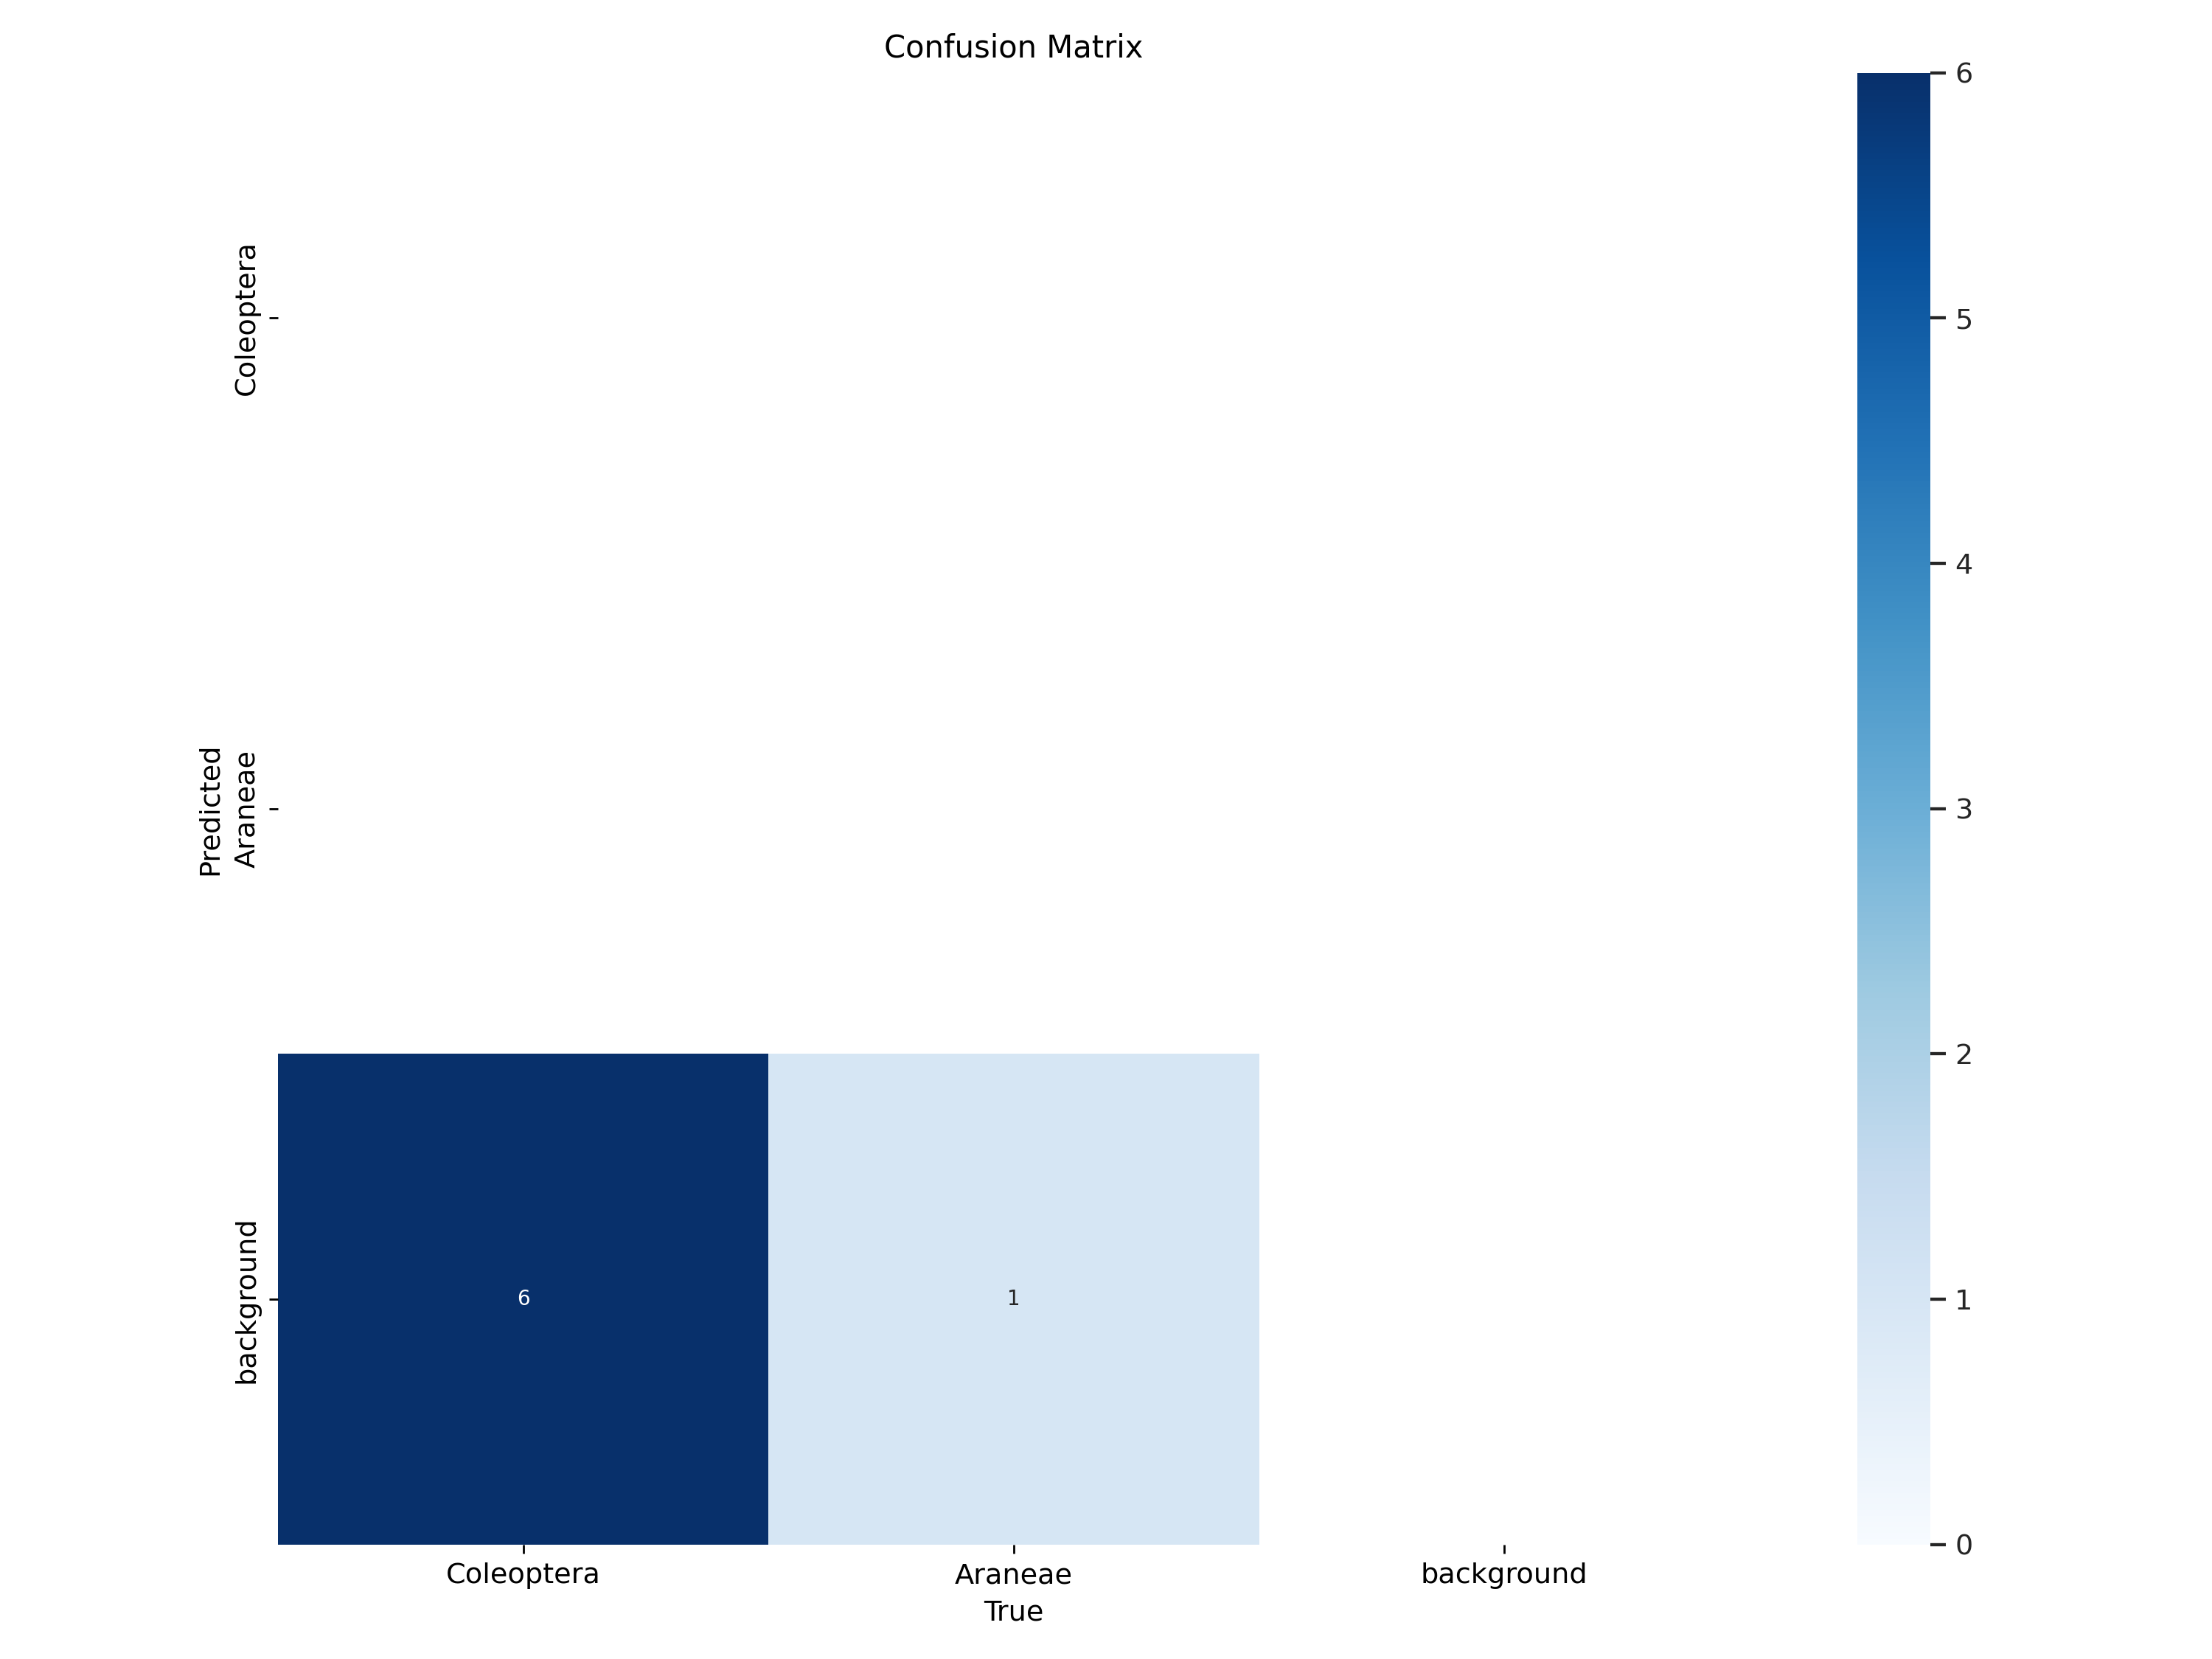

In [79]:
from IPython.display import Image
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=800)

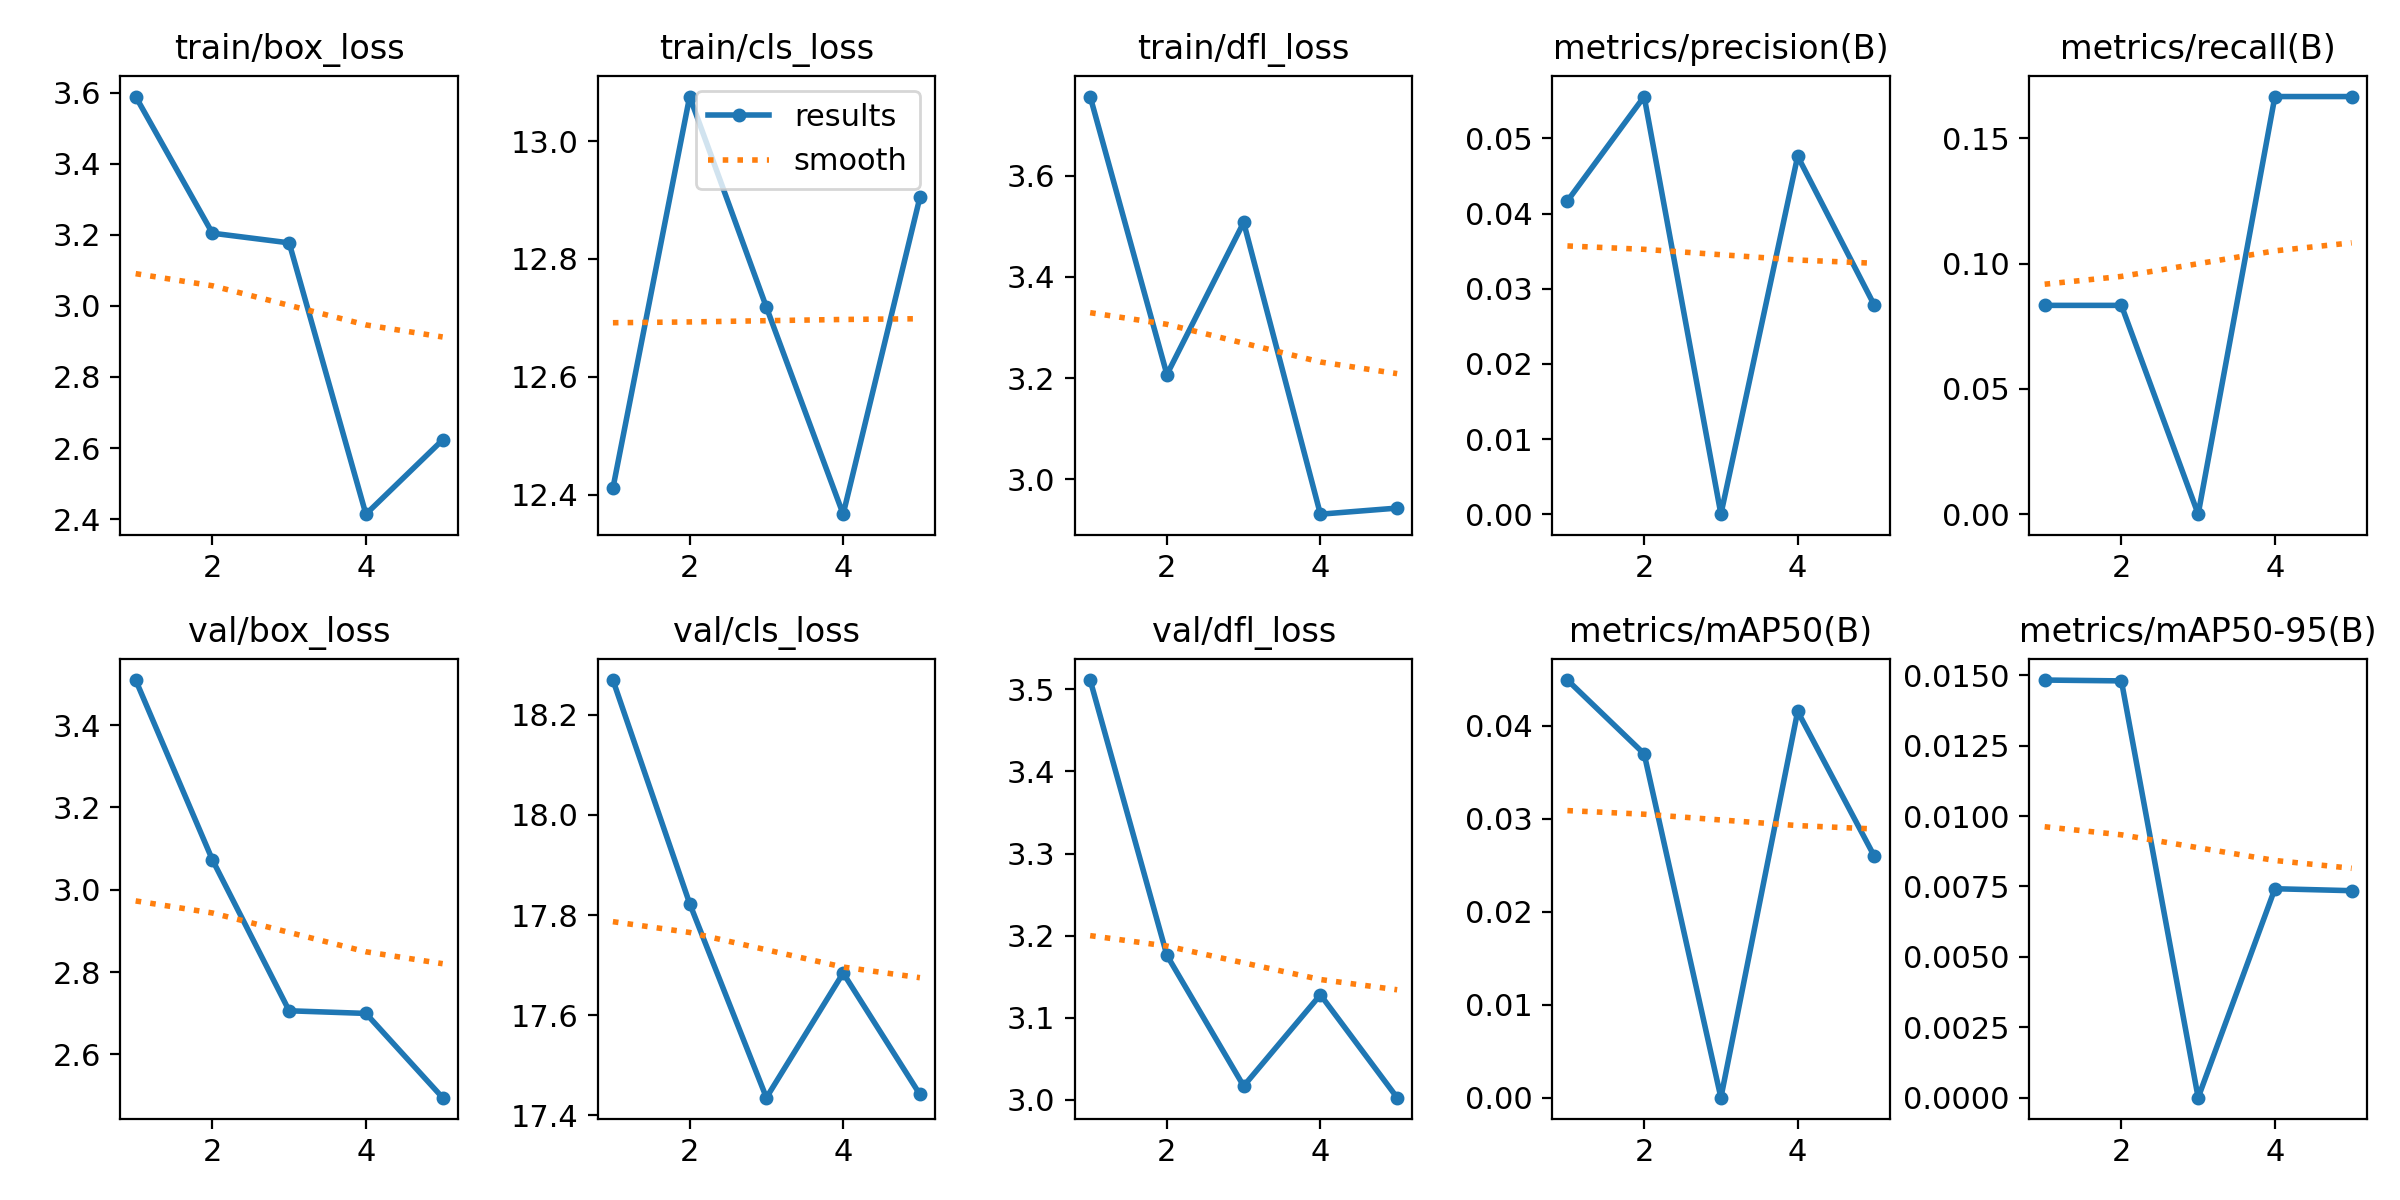

In [80]:
Image(filename=f'{HOME}/runs/detect/train/results.png', width=800)

In [88]:
from ultralytics import YOLO
import supervision as sv

model = YOLO(f'{HOME}/runs/detect/train/weights/best.pt')

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{HOME}/dataf/valid/images",
    annotations_directory_path=f"{HOME}/dataf/valid/labels",
    data_yaml_path=f"{HOME}/dataf/data.yaml"
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

ValueError: invalid literal for int() with base 10: '0.0'

SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.



0: 448x640 (no detections), 302.4ms
Speed: 6.1ms preprocess, 302.4ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


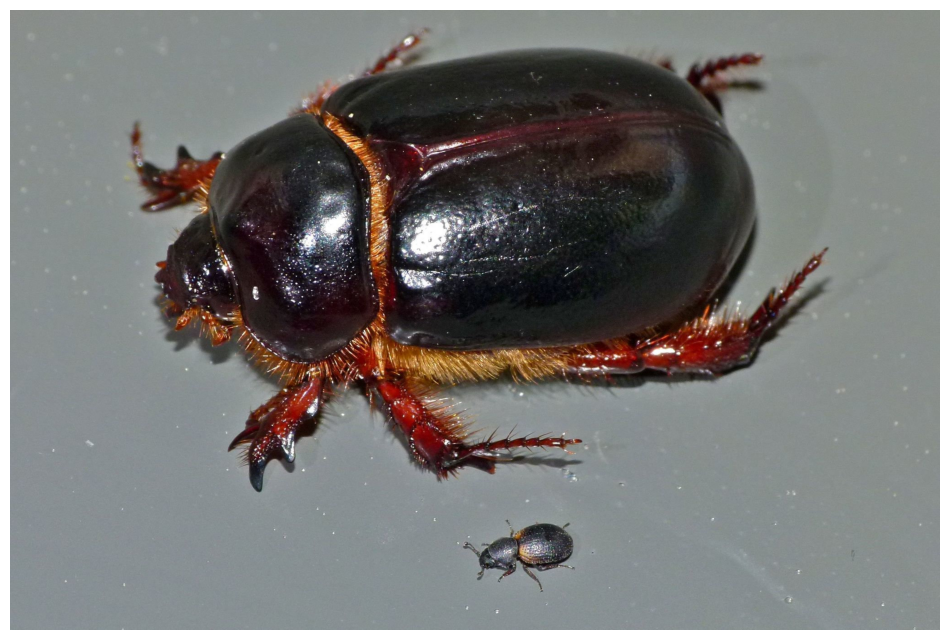

In [86]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [85]:
from ultralytics import YOLO

# Load a model
model = YOLO(f'{HOME}/runs/detect/train/weights/best.pt')  # load a custom model

# Validate the model
validation_results = model.val(data=f"{HOME}/dataf/data.yaml", imgsz=640, batch=32, conf=0.25, iou=0.5)  # no arguments needed, dataset and settings remembered

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLOv10n summary (fused): 125 layers, 2,695,196 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /content/dataf/valid/labels.cache... 503 images, 0 backgrounds, 0 corrupt: 100%|██████████| 503/503 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:55<00:00, 10.98s/it]


                   all        503        503          0          0          0          0
            Coleoptera        249        249          0          0          0          0
               Araneae        254        254          0          0          0          0
Speed: 7.2ms preprocess, 307.4ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val3


In [87]:
print(validation_results.box.map)  # map50-95
print(validation_results.box.map50)  # map50
print(validation_results.box.map75)  # map75
print(validation_results.box.maps)  # a list contains map50-95 of each category

0.0
0.0
0.0
[          0           0]
